# Venice Flooding Prediction System ML
This project is designed to predict when Venice will be flooded. Venice is frequently flooded, and this is a problem, having an AI that can predict this could help the tourists and citizens of the city to take the necessary precautions.

By Beatrice Marro

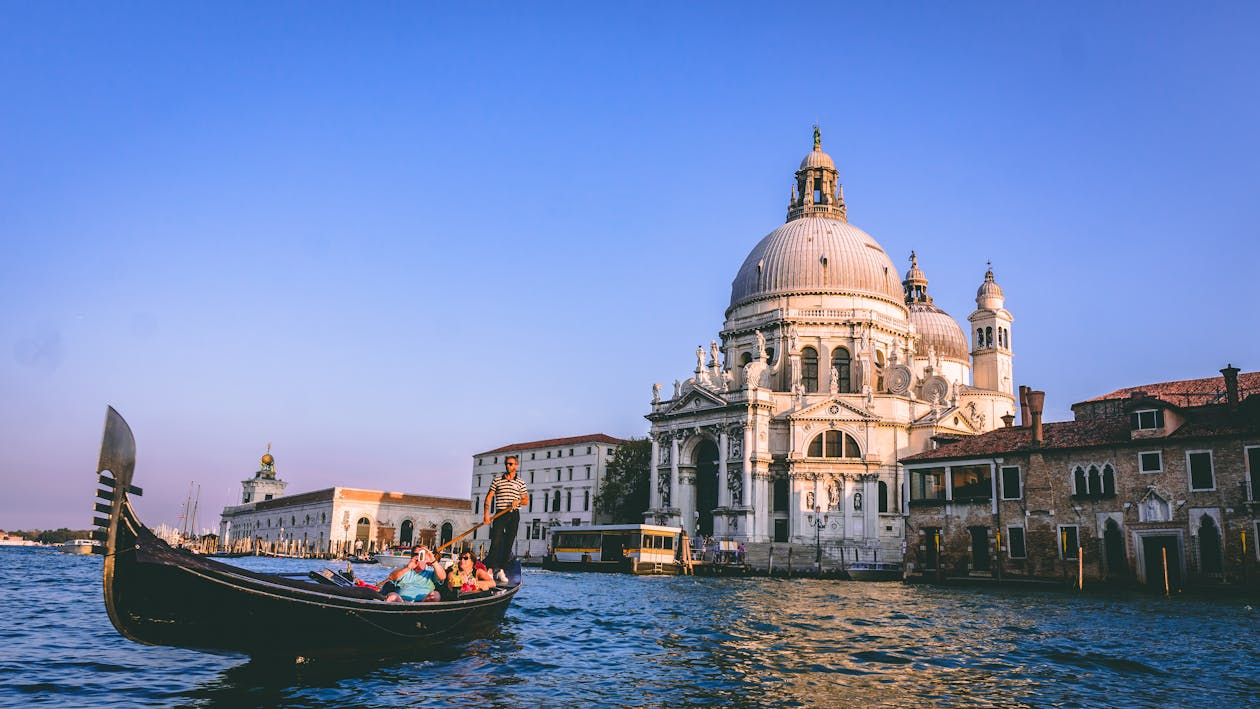

Import Libraries:

In [1]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import csv

print("scikit-learn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)

scikit-learn version: 1.3.0
pandas version: 2.0.3
seaborn version: 0.12.2
numpy version: 1.24.3


#### Sea Level Tide Gauge Data

In [2]:
# Sea level is measured in mm
columns = ["Year", "Month", "Sea Level (mm)"]

df = pd.read_csv("Full Sea Monthly Data Venice.csv", names=columns)
df.head()

Year  Month  Sea Level (mm)
0  2001      3            7029
1  2001      4            6870
2  2001      5            6925
3  2001      6            6880
4  2001      7            6901

In [3]:
df.describe()

Year       Month  Sea Level (mm)
count   262.000000  262.000000      262.000000
mean   2011.580153    6.538168     6993.595420
std       6.313586    3.443645      105.053482
min    2001.000000    1.000000     6662.000000
25%    2006.000000    4.000000     6932.250000
50%    2012.000000    7.000000     6998.000000
75%    2017.000000    9.750000     7053.500000
max    2022.000000   12.000000     7382.000000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Year            262 non-null    int64
 1   Month           262 non-null    int64
 2   Sea Level (mm)  262 non-null    int64
dtypes: int64(3)
memory usage: 6.3 KB


#### Sea Level Adjustments

In [5]:
# Deduct 4.473m from the water level
# 4.473 * 1000 = 4473

sea_levels_surface = []

for sea_level_mm in df["Sea Level (mm)"]:
    sea_level_surface = sea_level_mm - 4473
    sea_levels_surface.append(sea_level_surface)
    
df["Sea Level (mm)"] = sea_levels_surface

In [6]:
# 4.473m vs 1.5m below the sea level
# Lido di Venezia: Highest elevation: 3 m (10 ft)
# Venezia (centro): Elevation: 1 m (3 ft)

# Lido di Venezia is 2 meters above the central Venice

sea_levels_surface = []

for sea_level_mm in df["Sea Level (mm)"]:
    sea_level_surface = sea_level_mm - 1500 # 1.5 meters
    sea_levels_surface.append(sea_level_surface)
    
df["Sea Level (mm)"] = sea_levels_surface

#### Convert Sea Level from mm to cm

In [7]:
sea_level_converted = []

for sea_level_mm in df["Sea Level (mm)"]:
    sea_level_cm = sea_level_mm / 10
    sea_level_converted.append(sea_level_cm)
    
df["Sea Level (mm)"] = sea_level_converted 
# Rename column
df.rename(columns={"Sea Level (mm)": "Sea Level (cm)"}, inplace=True)

#### Sea Tide Levels

In [8]:
df_tide_levels = pd.read_csv("combined_tide_data.csv")
df_tide_levels.head()

Date  Tide Level (cm)
0  2001-01-01        40.422500
1  2001-02-01        26.357093
2  2001-03-01        41.762829
3  2001-04-01        24.606061
4  2001-05-01        29.250312

#### Wind and Pressure

In [9]:
df_wind_pressure = pd.read_csv("POWER_Point_Monthly_Timeseries_2001_2022_Wind_Pressure.csv")
df_wind_pressure.head()

PARAMETER  YEAR     JAN     FEB     MAR     APR     MAY     JUN     JUL  \
0        PS  2001  101.60  101.72  100.80  101.11  101.36  101.34  101.25   
1        PS  2002  102.64  101.69  101.65  101.26  101.28  101.42  101.17   
2        PS  2003  101.38  102.05  102.18  101.50  101.59  101.35  101.30   
3        PS  2004  101.14  101.77  101.95  101.17  101.22  101.43  101.38   
4        PS  2005  102.03  101.46  101.55  101.38  101.43  101.53  101.20   

      AUG     SEP     OCT     NOV     DEC     ANN  
0  101.37  101.15  101.97  101.80  102.01  101.46  
1  101.14  101.39  101.37  101.11  101.65  101.48  
2  101.36  101.83  101.23  101.86  101.89  101.62  
3  101.21  101.76  101.43  101.68  101.82  101.49  
4  101.29  101.63  102.07  101.68  101.55  101.57

#### Temperatures and Thermal IR Flux

In [10]:
df_temperature = pd.read_csv("POWER_Point_Monthly_Timeseries_2001_2022_Temperatures_Thermal_IR_Flux.csv")
df_temperature.head()

PARAMETER  YEAR   JAN   FEB    MAR    APR    MAY    JUN    JUL    AUG  \
0        TS  2001  7.74  7.15  10.68  12.60  19.26  21.55  25.23  26.63   
1        TS  2002  3.84  6.57  10.19  12.90  18.15  23.83  24.94  24.17   
2        TS  2003  5.65  4.29   8.57  11.48  19.47  26.44  27.20  28.62   
3        TS  2004  4.89  5.07   7.46  12.48  16.37  21.36  24.83  25.66   
4        TS  2005  5.00  4.26   7.71  12.04  18.08  23.19  25.65  23.62   

     SEP    OCT    NOV   DEC    ANN  
0  19.66  17.87  10.96  5.23  15.44  
1  20.39  16.47  13.04  8.53  15.30  
2  20.79  15.04  11.45  7.21  15.58  
3  21.53  17.31  11.70  7.94  14.75  
4  21.34  15.71  10.80  6.38  14.54

#### Surface Pressure

In [11]:
df_surface_pressure = pd.read_csv("POWER_Point_Monthly_2001_2022_Surface_Pressure.csv")
df_surface_pressure.head()

PARAMETER  YEAR     JAN     FEB     MAR     APR     MAY     JUN     JUL  \
0        PS  2001  101.60  101.72  100.80  101.11  101.36  101.34  101.25   
1        PS  2002  102.64  101.69  101.65  101.26  101.28  101.42  101.17   
2        PS  2003  101.38  102.05  102.18  101.50  101.59  101.35  101.30   
3        PS  2004  101.14  101.77  101.95  101.17  101.22  101.43  101.38   
4        PS  2005  102.03  101.46  101.55  101.38  101.43  101.53  101.20   

      AUG     SEP     OCT     NOV     DEC     ANN  
0  101.37  101.15  101.97  101.80  102.01  101.46  
1  101.14  101.39  101.37  101.11  101.65  101.48  
2  101.36  101.83  101.23  101.86  101.89  101.62  
3  101.21  101.76  101.43  101.68  101.82  101.49  
4  101.29  101.63  102.07  101.68  101.55  101.57

##### Dataset Information:
- **Dataset**: NASA/POWER CERES/MERRA2 Native Resolution Monthly and Annual
- **Dates (month/day/year)**: 01/01/2001 through 12/31/2022
- **Location**: Latitude 45.4347, Longitude 12.3341
- **Elevation from MERRA-2**: Average for 0.5 x 0.625 degree lat/lon region = 8.66 meters
- **Missing Data Value**: -999 (for data that cannot be computed or is outside of the sources availability range)

**Parameters:**
- PS: MERRA-2 Surface Pressure (kPa)

In [12]:
df_surface_pressure = pd.read_csv("POWER_Point_Monthly_2001_2022_Surface_Pressure.csv")
df_surface_pressure.head()

PARAMETER  YEAR     JAN     FEB     MAR     APR     MAY     JUN     JUL  \
0        PS  2001  101.60  101.72  100.80  101.11  101.36  101.34  101.25   
1        PS  2002  102.64  101.69  101.65  101.26  101.28  101.42  101.17   
2        PS  2003  101.38  102.05  102.18  101.50  101.59  101.35  101.30   
3        PS  2004  101.14  101.77  101.95  101.17  101.22  101.43  101.38   
4        PS  2005  102.03  101.46  101.55  101.38  101.43  101.53  101.20   

      AUG     SEP     OCT     NOV     DEC     ANN  
0  101.37  101.15  101.97  101.80  102.01  101.46  
1  101.14  101.39  101.37  101.11  101.65  101.48  
2  101.36  101.83  101.23  101.86  101.89  101.62  
3  101.21  101.76  101.43  101.68  101.82  101.49  
4  101.29  101.63  102.07  101.68  101.55  101.57

#### Wind Direction
This data shows the wind direction at the height of 10 meters.

A strong **south-east wind (“scirocco”)** contributes to strong tides, which in turn contribute to high sea levels and flooding.

For a wind to be in the south direction it needs to from roughly 125 to 145 degrees.

In [13]:
df_wind_direction = pd.read_csv("POWER_Point_Monthly_2001_2022_Wind_Direction.csv")
df_wind_direction.head()

PARAMETER  YEAR    JAN    FEB     MAR     APR     MAY     JUN     JUL  \
0     WD10M  2001  52.75  64.31  127.12  115.31   97.38  116.81  128.44   
1     WD10M  2002  68.88  62.00   79.25   78.12  111.50  126.94  104.69   
2     WD10M  2003  59.00  67.19  105.88   72.62   96.50  117.25  107.44   
3     WD10M  2004  48.81  46.44   67.94   80.19  150.81   92.56  103.38   
4     WD10M  2005  30.19  56.75   87.69  107.44   95.81  118.12  102.12   

      AUG     SEP     OCT     NOV    DEC    ANN  
0  100.94  121.31  123.19   52.19  58.00  85.44  
1   98.94   81.75  108.38  130.75  61.50  89.06  
2  119.38   86.44   79.94   66.25  47.19  79.00  
3  133.44   90.19  110.94   48.75  54.19  76.25  
4   90.75   85.00   67.06   41.94  34.50  72.06

#### Figure Number

In [14]:
figure_number = 0

def get_figure_number():
    global figure_number
    figure_number += 1
    return figure_number

**Venice Flood Sea Levels Information**:
- When water level is above 110 cm, this will cause a partial flooding (12% of the city).
- A very powerful tide could flood venice at the point where the water level reaches 140cm, in this case the city will be entirely flooded.

It seems that in most months the temperature increased from 2001 to 2022, particularly during the months of summer. This makes sense due to Global Warming, also there seems to be a link here, as there was the same effect for the rise in the sea level.

Given that the temperature data varies with season factors and over time, this would be a great feature to include in the time series model.

For the wind speed average per month this really varies, and unlike the sea levels and temperature, it is not really something that relies on the season factors. Due to this, I think this would not be a good feature to include in the time series model as it would only add noise to the model.

# Machine Learning
The sea level is a **non-stationary time series**, as it changes over time and is prone to seasonal factors.

However, time series models need a **stational time series** to for the modelling.

Transformations to turn time series data from non-stationary to stationery:
- Differencing the Series (once or more)
- Take the log of the series
- Take the nth root of the series
- Combination of the above

The most commonly used and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

### Confirming if the time series is non-stationary via testing
#### Augmented Dickey Fuller test (ADF Test)
The Augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.

It works by using the formula below, the meaning of each variable are the following:
- **Δyt** is the first difference of the series at time *t*, which is calculated as `Y = Yt – Yt-1`.
- **β** is the coefficient on a time trend.
- **p** is the lag order of the autoregressive process
- **γ** is the coefficient of the lagged value of the time series. It measures the impact of the previous value of the series on its current change.
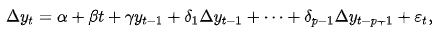

Essentially, it uses these variables to determine if there are trends in the data via this calculation, if the data does have non-stationary data, it will be able to detect this, and the confidence level will be calculate as the `p-value`, the closer it is to 0, the higher the confidence that the time series is non-stationary, and should thus be converted to a stationary time series.

- A `p-value` close to **0** indicates **strong** evidence against the null hypothesis.
- A `p-value` close to **1** indicates **weak** evidence against the null hypothesis.

Where the null hypothesis means that it is a stationary time series.

Source - Article on Kaggle: https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

In [15]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

# Initialize an empty list to store temperature data
monthly_averages = []

# 2001 to 2022
years = range(2001, 2023)

def get_yearly_and_monthly_average(df, parameter):
    monthly_averages = []
    for year in years:
        for month in months:
            average_monthly_value = df[(df["PARAMETER"] == parameter) & (df["YEAR"] == year)][month].mean()
            monthly_averages.append(average_monthly_value)
    return monthly_averages

monthly_temperature_averages = get_yearly_and_monthly_average(df_temperature, "T2M")
monthly_surface_pressure_averages = get_yearly_and_monthly_average(df_surface_pressure, "PS")
monthly_wind_pressure_averages = get_yearly_and_monthly_average(df_wind_pressure, "WS2M")

In [16]:
from statsmodels.tsa.stattools import adfuller

def check_adf_test(y):
    result = adfuller(y)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

    if result[1] > 0.05:
        print("The series is non-stationary and requires differencing.")
    else:
        print("The series is stationary and does not require differencing")
    
# Sea Level
print("Sea Level")
check_adf_test(df["Sea Level (cm)"])

print("\nTemperature")
check_adf_test(monthly_temperature_averages)

print("\nSurface Pressure")
check_adf_test(monthly_surface_pressure_averages)

print("\nWind Pressure")
check_adf_test(monthly_wind_pressure_averages)

Sea Level
ADF Statistic: -2.457453584989565
p-value: 0.126172397495735
The series is non-stationary and requires differencing.

Temperature
ADF Statistic: -2.693444917456756
p-value: 0.07517946971943175
The series is non-stationary and requires differencing.

Surface Pressure
ADF Statistic: -5.078690460788759
p-value: 1.547016087981971e-05
The series is stationary and does not require differencing

Wind Pressure
ADF Statistic: -3.639459538012932
p-value: 0.005049942009550716
The series is stationary and does not require differencing


For the **Sea Level**, the `p-value` confirms that is a non-stationary time series, with a fair level of confidence, this is also shown by the value of the `ADF Statistic` which is negative.

Whereas for the **Temperature**, **Surface Pressure** and the **Wind Pressure** the `p-value`is below 0.05, therefore the time series is considered as stationary. This is quite weird as the temperature is something that changes over time, perhaps it is because this is similar most years so not showing major patterns, whereas this could vary more for the sea level.

### Converting to stationary time series
If `Y_t` is the value at time t, then the first difference of `Y = Yt – Yt-1`. Basically, differencing the series is subtracting the next value by the current value.

In [17]:
def apply_differencing(y):
    y_diff = y.diff().dropna()

    # Perform the ADF test on the differenced series
    result_diff = adfuller(y_diff)
    print("ADF Statistic after differencing:", result_diff[0])
    print("p-value after differencing:", result_diff[1])

apply_differencing(df["Sea Level (cm)"])

ADF Statistic after differencing: -9.231178995586367
p-value after differencing: 1.6767399057704595e-15


-- **The section above is not needed by Prophet!** --

While the conversion of a stationary time series to non-stationary time series is not requested by Prophet, it is used in other types of time series models.

## Prophet Time Series Model
Prophet needs for the columns of the time series to match a specific format, this should be in a DataFrame in which there are 2 columns, **DS** and **Y**. DS is the date in the format `YYYY-MM-DD`, whereas Y is the value of the variable, in this case an example of this would be the sea level.

In [18]:
# Convert sea level columns to be in the format
# Date: 2001-01-01
# Sea Level (cm): 110

import datetime

dates_sea_level = []

for month, year in zip(df["Month"], df["Year"]):
    date = datetime.datetime(year, month, 1) # Set day as 1 as I do not have this in my dataset
    dates_sea_level.append(date)

Now we have converted all months and years into concrete dates. This means that now we can create the DataFrame in the format that works for Prophet.

In [19]:
sea_data_time_series = []

for date, sea_level in zip(dates_sea_level, df["Sea Level (cm)"]):
    sea_data_time_series.append([date, sea_level])
 
# Create the pandas DataFrame
df_sea_level_time_series = pd.DataFrame(sea_data_time_series, columns=["ds", "sea_level"])

df_sea_level_time_series.sample(5)

ds  sea_level
31  2003-10-01       99.1
62  2006-05-01       93.7
200 2017-11-01      113.2
0   2001-03-01      105.6
228 2020-03-01      100.6

### Converter from NASA Power DAVe Format to Prophet Format

The data from the NASA Power DAVe has a format very different to that requested by Prophet. The function below is reusable to convert any dataframe from the NASA web application to the desired Prophet dataframe format.

In [20]:
def convert_nasa_to_prophet_format(df, selected_parameter, variable_name):
    sub_list = []
        
    for index, row in df.iterrows():
        parameter = row["PARAMETER"]
        if parameter == selected_parameter:
            for year in range(2001, 2023):
                if row["YEAR"] == year:
                    for month in months:
                        average_variable_level = row[month]
                        month_number = months.index(month) + 1

                        date = datetime.datetime(year, month_number, 1) # Set day to 1
                        sub_list.append([date, average_variable_level])
        
    return pd.DataFrame(sub_list, columns=["ds", variable_name])

Below I am applying the conversions to all of the variables to ensure that they are in the suitable format for Prophet:

#### Convert Temperature data to suitable format

In [21]:
df_temperature_time_series = convert_nasa_to_prophet_format(df_temperature, "T2M", "temperature")
df_temperature_time_series

ds  temperature
0   2001-01-01         6.53
1   2001-02-01         7.40
2   2001-03-01        10.76
3   2001-04-01        12.57
4   2001-05-01        19.53
..         ...          ...
259 2022-08-01        26.62
260 2022-09-01        21.23
261 2022-10-01        18.89
262 2022-11-01        12.71
263 2022-12-01         7.86

[264 rows x 2 columns]

#### Convert Wind Direction data to suitable format

In [22]:
df_wind_direction_time_series = convert_nasa_to_prophet_format(df_wind_direction, "WD10M", "wind_direction")
df_wind_direction_time_series

ds  wind_direction
0   2001-01-01           52.75
1   2001-02-01           64.31
2   2001-03-01          127.12
3   2001-04-01          115.31
4   2001-05-01           97.38
..         ...             ...
259 2022-08-01           89.12
260 2022-09-01          113.50
261 2022-10-01           99.81
262 2022-11-01           52.12
263 2022-12-01           45.12

[264 rows x 2 columns]

In [23]:
# Convert to sine of value
wind_directions_binary = []
for date, wind_direction in zip(df_wind_direction_time_series["ds"], df_wind_direction_time_series["wind_direction"]):
    if wind_direction > 115 and wind_direction < 145:
        wind_directions_binary.append([date, np.sin(wind_direction)])
    else:
        wind_directions_binary.append([date, 0])
        
df_wind_direction_time_series = pd.DataFrame(wind_directions_binary, columns=["ds", "wind_direction"])
df_wind_direction_time_series

ds  wind_direction
0   2001-01-01        0.000000
1   2001-02-01        0.000000
2   2001-03-01        0.993452
3   2001-04-01        0.800979
4   2001-05-01        0.000000
..         ...             ...
259 2022-08-01        0.000000
260 2022-09-01        0.000000
261 2022-10-01        0.000000
262 2022-11-01        0.000000
263 2022-12-01        0.000000

[264 rows x 2 columns]

#### Convert Wind Speed data to suitable format

In [24]:
df_wind_speed_time_series = convert_nasa_to_prophet_format(df_wind_pressure, "WS2M", "wind_speed")

wind_speed_converted = []

for date, wind_speed in zip(df_wind_speed_time_series["ds"], df_wind_speed_time_series["wind_speed"]):
    wind_speed_converted.append([date, wind_speed * 10])
    
df_wind_speed_time_series = pd.DataFrame(wind_speed_converted, columns=["ds", "wind_speed"])
df_wind_speed_time_series

ds  wind_speed
0   2001-01-01        30.7
1   2001-02-01        25.4
2   2001-03-01        27.0
3   2001-04-01        24.9
4   2001-05-01        21.6
..         ...         ...
259 2022-08-01        23.5
260 2022-09-01        24.7
261 2022-10-01        17.3
262 2022-11-01        26.6
263 2022-12-01        25.5

[264 rows x 2 columns]

#### Convert Surface Pressure data to suitable format

In [25]:
df_surface_pressure_time_series = convert_nasa_to_prophet_format(df_surface_pressure, "PS", "surface_pressure")
df_surface_pressure_time_series

ds  surface_pressure
0   2001-01-01            101.60
1   2001-02-01            101.72
2   2001-03-01            100.80
3   2001-04-01            101.11
4   2001-05-01            101.36
..         ...               ...
259 2022-08-01            101.21
260 2022-09-01            101.13
261 2022-10-01            102.05
262 2022-11-01            101.46
263 2022-12-01            101.60

[264 rows x 2 columns]

#### Tide Levels Conversion

In [26]:
df_tide_levels = df_tide_levels.rename(columns={"Date": "ds", "Tide Level (cm)": "tide_level"})
df_tide_levels

ds  tide_level
0    2001-01-01   40.422500
1    2001-02-01   26.357093
2    2001-03-01   41.762829
3    2001-04-01   24.606061
4    2001-05-01   29.250312
..          ...         ...
271  2023-08-01   39.945565
272  2023-09-01   37.913079
273  2023-10-01   46.914875
274  2023-11-01   52.736921
275  2023-12-01   41.847558

[276 rows x 2 columns]

In [27]:
df_sea_level_time_series["ds"] = pd.to_datetime(df_sea_level_time_series["ds"])
df_temperature_time_series["ds"] = pd.to_datetime(df_temperature_time_series["ds"])
df_tide_levels["ds"] = pd.to_datetime(df_tide_levels["ds"])

df_combined = df_sea_level_time_series.merge(df_tide_levels, on="ds", how="inner")
df_combined = df_combined.merge(df_wind_direction_time_series, on="ds", how="inner")
df_combined

ds  sea_level  tide_level  wind_direction
0   2001-03-01      105.6   41.762829        0.993452
1   2001-04-01       89.7   24.606061        0.800979
2   2001-05-01       95.2   29.250312        0.000000
3   2001-06-01       90.7   23.776992       -0.540534
4   2001-07-01       92.8   25.405978        0.357228
..         ...        ...         ...             ...
257 2022-08-01      105.6   30.905018        0.000000
258 2022-09-01      112.0   37.672222        0.000000
259 2022-10-01      104.8   30.920027        0.000000
260 2022-11-01      120.5   42.350463        0.000000
261 2022-12-01      120.6   43.582885        0.000000

[262 rows x 4 columns]

### Fitting the Model

In [28]:
from prophet import Prophet

# Optimal parameters according to Hyperparameter Tuning
params = {
    "changepoint_prior_scale": 0.01,
    "seasonality_prior_scale": 0.01,
    "holidays_prior_scale": 0.01,
    "changepoint_range": 0.1
}

m = Prophet(**params)

m.add_regressor("tide_level")
m.add_regressor("wind_direction")

m.fit(df_combined.rename(columns={"sea_level": "y"}))

11:30:59 - cmdstanpy - INFO - Chain [1] start processing
11:30:59 - cmdstanpy - INFO - Chain [1] done processing


### Hyperparameter Tuning
Below I am doing Hyperparameter Tuning, for the following paramters, below I explain what each of them means:
- `changepoint_prior_scale`: This value controls the sensibility of the model to changes in trends in the model. Lower values are used to make the trends smoother (applying regularization techniques), whereas the use of higher values will allow more flexibility for the more diverse changes in the trends.
- `seasonality_prior_scale`: This value is used to apply a certain level of regularization for the seasonal component. A higher value will lead to more flexibility in capturing the more diverse changes in the trends, whereas a lower value leads to smoother estimates for seasonal patterns.
- `holidays_prior_scale`: This value is the strength of the regularization for the holiday effects throughout the year. Lower values apply a stronger regularization effect for the holiday periods, in this way the holiday periods have a much less significant effect on the time series, whereas the opposite happens when a lower regularization is applied.
- `changepoint_range`: The proportion of the historical data within which changepoints can to be placed.

In [29]:
print("Hyperameters currently in use by Prophet:\n")

print(f"changepoint_prior_scale: {m.changepoint_prior_scale}")
print(f"seasonality_prior_scale: {m.seasonality_prior_scale}")
print(f"holidays_prior_scale: {m.holidays_prior_scale}")
print(f"seasonality_mode: {m.seasonality_mode}")
print(f"changepoint_range: {m.changepoint_range}")

Hyperameters currently in use by Prophet:

changepoint_prior_scale: 0.01
seasonality_prior_scale: 0.01
holidays_prior_scale: 0.01
seasonality_mode: additive
changepoint_range: 0.1


In [30]:
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

cutoffs = pd.to_datetime(["2013-02-15", "2013-08-15", "2014-02-15"])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon="365 days")

param_grid = {  
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "seasonality_mode": ["additive", "multiplicative"],
    "changepoint_range": [0.7, 0.8, 0.9],
}

df_combined = df_combined.rename(columns={"sea_level": "y"})

print(df_combined)

# All possible combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

for params in all_params:
    m = Prophet(**params).fit(df_combined)  # Fit model with given params

    df_cv = cross_validation(m, cutoffs=cutoffs, horizon="30 days", parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p["rmse"].values[0])

# Find best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["rmse"] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

In [31]:
print("Best Hyperparameters after Grid Search:")
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}

Best Hyperparameters after Grid Search:


{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.9}

Out of these hyperparameters given by the grid search, I found that the value for the `seasonality_prior_scale` worked really well for my model. Also, for the `changepoint_prior_scale` and `seasonality_mode`, I found that the values worked fine, but latest on I tweaked them, and I found that the accuracy was optimal with a `changepoint_prior_scale` of 0.01 and a `changepoint_range` of 0.1. In addition to this, according to the hyperparameter tuning, the best `seasonality_model` is `multiplicative`, although I tested this, and it was detrimental to the accuracy, thus I found out that keep it as `additive` (the default value) worked well.

I understand that sometimes the grid search may not provide the most optimal hyperparameters for the model, but this is because it is provided with limited data, and with that data it tries to find the best combination of hyperparameters. However, it is a great tool in getting closer to the most suitable hyperparameters to use for a model.

## Back to the model

The code below is used to make predictions for the selected amount of days in the future compared to dataset end date. The records displayed are the most recent ones.

In [32]:
future = m.make_future_dataframe(periods=1826) # Next five years (until 2027)
future.tail()

ds
2083 2027-11-27
2084 2027-11-28
2085 2027-11-29
2086 2027-11-30
2087 2027-12-01

The code below is to make the predictions for the dates selected in the previous step. The meaning of each of the columns are thf following:
- `ds`: The date for the forecasted value.
- `yhat`: The predicted value (forecast) for that given date.
- `yhat_lower`: The lower bound of the prediction interval.
- `yhat_upper`: The upper bound of the prediction interval.

In [33]:
def get_historical_average_temperature(date):
    month = date.month
    avg_temp = df_temperature_time_series[df_temperature_time_series["ds"].dt.month == month]["temperature"].mean()
    return avg_temp

def get_historical_average_tide_level(date):
    month = date.month
    avg_tide = df_tide_levels[df_tide_levels["ds"].dt.month == month]["tide_level"].mean()
    return avg_tide

def get_historical_average_wind_direction(date):
    month = date.month
    avg_wind_direction = df_wind_direction_time_series[df_wind_direction_time_series["ds"].dt.month == month]["wind_direction"].mean()
    return avg_wind_direction

def get_historical_average_wind_speed(date):
    month = date.month
    avg_wind_speed = df_wind_speed_time_series[df_wind_speed_time_series["ds"].dt.month == month]["wind_speed"].mean()
    return avg_wind_speed

future["tide_level"] = future["ds"].apply(get_historical_average_tide_level)
future["wind_direction"] = future["ds"].apply(get_historical_average_wind_direction)

forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

ds        yhat  yhat_lower  yhat_upper
2083 2027-11-27  118.072723  115.045566  120.964931
2084 2027-11-28  118.177423  115.392698  121.178053
2085 2027-11-29  118.271531  115.186412  121.248261
2086 2027-11-30  118.353083  115.387721  121.181082
2087 2027-12-01  110.849406  107.982381  113.787156

The diagram  below displays the part and the forecast sea levels in Venice.

Interesting website about advanced features of Prophet: https://mkang32.github.io/python/2020/12/15/prophet-intro.html

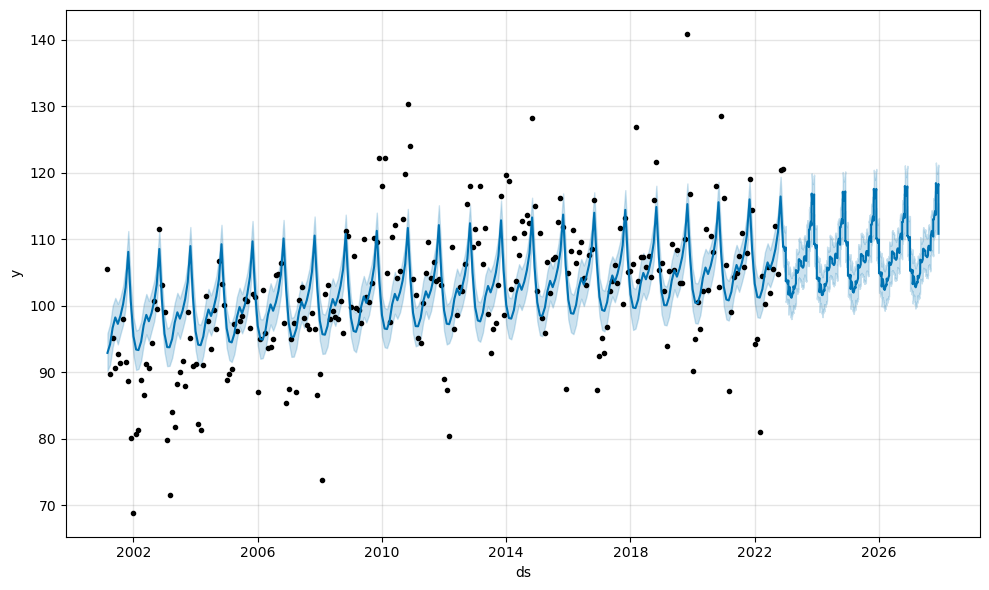

In [34]:
fig1 = m.plot(forecast)

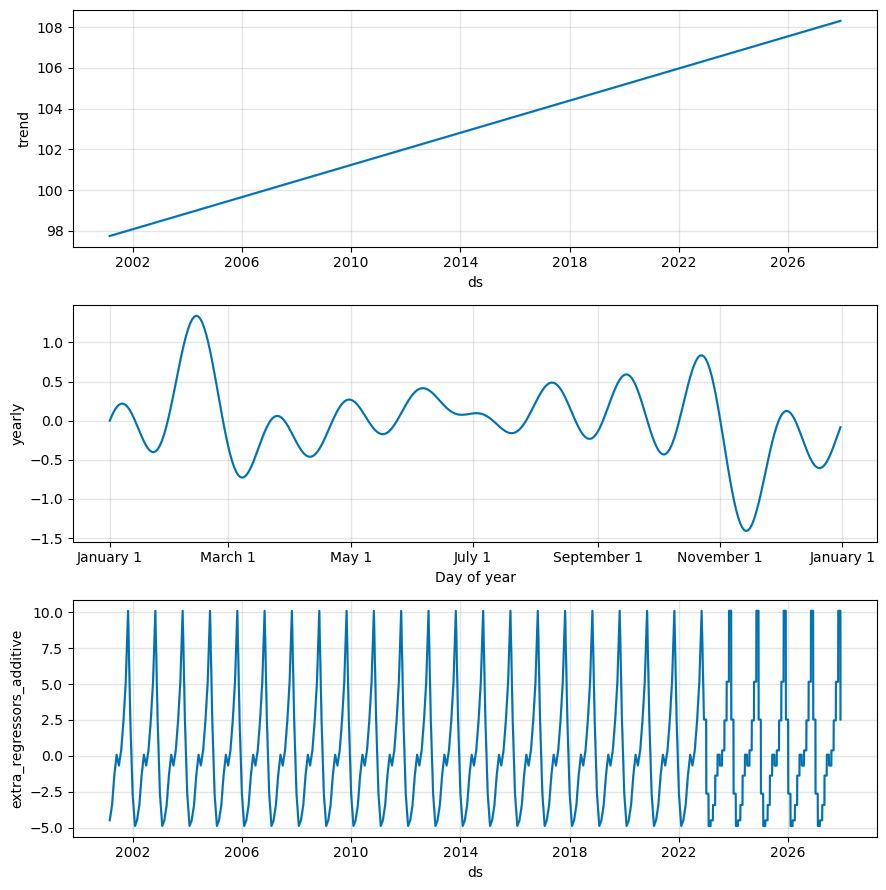

In [35]:
fig2 = m.plot_components(forecast)

In [36]:
forecast_pred = m.make_future_dataframe(periods=1826) # 5 years (until 2027)

mean_sea_level = df_combined["sea_level"].mean()
forecast_pred["sea_level"] = mean_sea_level

mean_tide_level = df_combined["tide_level"].mean()
forecast_pred["tide_level"] = mean_tide_level

mean_wind_direction = df_combined["wind_direction"].mean()
forecast_pred["wind_direction"] = mean_wind_direction

# Make predictions
pred = m.predict(forecast_pred)

from prophet.plot import plot_plotly
fig = plot_plotly(m, pred)
fig.show()

### Accuracy
The code below aims at finding an accuracy for the time series model.

This is calculated in terms of 3 different performance metrics:
1. **Mean Absolute Error (MAE)** - This is the average absolute error between the predicted values and the actual values.
2. **Mean Squared Error (MSE)** - This is the difference between the squares of the prediced and actual values.
3. **Root Mean Squared Error (RMSE)** - This is the square root of the mean squared error. It is measured in the same units as the target (in this case cm).
4. **R²** - This is the accuracy of the model.

#### What values indicate a high accuracy:
Lower values indicate a high accuracy, as it means that the predicted values are closer to the real values.

Link: https://martinxpn.medium.com/time-series-analysis-with-python-using-prophet-98-100-days-of-python-689b26e8e222#:~:text=Prophet%20offers%20a%20built%2Din,to%20assess%20the%20model's%20accuracy.

In [37]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# cross-validation
# This is form of a train/test split. This splits the data into sets to be able to test the model using previous unseen data.

# Intial - intial size of training period = 2 years
# Period - number of days that make up a validation interval = 6 months
# Horizon - How far in the future the model should make predictions = 5 years
df_cv = cross_validation(m, initial="720 days", period="180 days", horizon="1826 days")

# performance metrics
df_metrics = performance_metrics(df_cv)

# Calculate MAE, MSE, RMSE and R²
mae = mean_absolute_error(df_cv["y"], df_cv["yhat"])
mse = mean_squared_error(df_cv["y"], df_cv["yhat"])
rmse = np.sqrt(mse)
r2 = r2_score(df_cv["y"], df_cv["yhat"])

print(f"Mean Absolute Error: {mae:.2f} cm")
print(f"Mean Squared Error: {mse:.2f} cm²")
print(f"Root Mean Squared Error: {rmse:.2f} cm")
print(f"R² Score: {r2:.2f}")

  0%|          | 0/30 [00:00<?, ?it/s]

11:31:13 - cmdstanpy - INFO - Chain [1] start processing
11:31:13 - cmdstanpy - INFO - Chain [1] done processing
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:15 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:15 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:16 - cmdstanpy - INFO - Chain [1] done processing
11:31:16 - cmdstanpy - INFO - Chain [1] start processing
11:31:16 - cmdstanpy - INFO - Chain [1] done processing
11:31:17 - cmdstanpy - INFO - Chain [1] start processing
11:31:17 - cmdstanpy - INFO - Chain [1] done processing
11:31:17 - cmdstanpy - INFO - Chain [1] start processing
11:31:17 - cmdstanpy - INFO - Chain [1] done processing
11:31:18 - cmdstanpy - INFO - Chain [1] start processing
11:31:18 - cmdstanpy - INFO - Chain [1]

Mean Absolute Error: 3.77 cm
Mean Squared Error: 20.82 cm²
Root Mean Squared Error: 4.56 cm
R² Score: 0.76


Based on the metrics calculated, I can conclude the following:
- **R² Score**: This the main metric for the accuracy. This score is very good considering the challenge of the task itself, it means that the model is fairly accurate in predicting the sea level of Venice for the next 5 years.
- **Mean Absolute Error**: This is the average offset of the results predicted by my model compared to the actual results. This offset is not so significant as it is 3.77 cm, which is fairly reasonable.
- **Mean Squared Error**: This is the average offset of the squares of the results predicted by my model compared to the actual results. This is also quite reasonable at 20.82 cm².
- **Root Mean Squared Error**: This is the square root for the Mean Squared Error. It is also quite reasonable being 4.56 cm.

### Evaluation

In [38]:
def get_flood_alert(predicted_sea_level):
    if predicted_sea_level > 110:
        print("This should be a relative flood of about 10% of Venice")
    elif predicted_sea_level > 140:
        print("This should be a large flood with about 80% of Venice being flooded")
    else:
        print("No flooding should occur at this time")

In [39]:
def predict_sea_level(month, year):
    test_date = f"{year}-{month}-1"
    # Filter the forecast DataFrame for the test date and extract the yhat value
    predicted_sea_level = forecast[forecast["ds"] == test_date]["yhat"].values[0]
    get_flood_alert(predicted_sea_level)
    return predicted_sea_level
    
print(f"Predicted Sea Level: {round(predict_sea_level(6, 2024), 1)} cm")

No flooding should occur at this time
Predicted Sea Level: 107.4 cm


In [40]:
def get_predicted_values_list(year):
    predicted_sea_levels = []
    for month in months:
        month_number = months.index(month) + 1
        monthly_sea_level = predict_sea_level(month, year)
        predicted_sea_levels.append(monthly_sea_level)
        
    return predicted_sea_levels
        
predicted_sea_levels_2023 = get_predicted_values_list(2023)
predicted_sea_levels_2024 = get_predicted_values_list(2024)
predicted_sea_levels_2025 = get_predicted_values_list(2025)
predicted_sea_levels_2026 = get_predicted_values_list(2026)

No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
This should be a relative flood of about 10% of Venice
This should be a relative flood of about 10% of Venice
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
No flooding should occur at this time
This should be a relative flood of about 10% of Venice
This should be a relative flood of about 10% of Venice
No flooding should occur at this time
No flooding should o

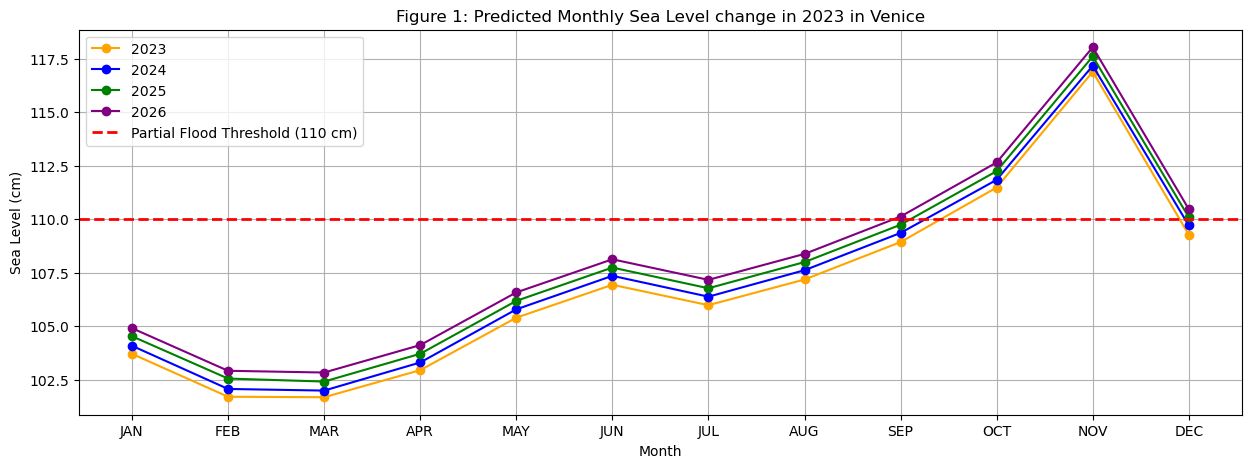

In [41]:
# Plot as line graph
plt.figure(figsize=(15, 5))

plt.plot(months, predicted_sea_levels_2023, marker="o", linestyle="-", color="orange", label="2023")
plt.plot(months, predicted_sea_levels_2024, marker="o", linestyle="-", color="blue", label="2024")
plt.plot(months, predicted_sea_levels_2025, marker="o", linestyle="-", color="green", label="2025")
plt.plot(months, predicted_sea_levels_2026, marker="o", linestyle="-", color="purple", label="2026")

plt.xlabel("Month")
plt.ylabel("Sea Level (cm)")
plt.title(f"Figure {get_figure_number()}: Predicted Monthly Sea Level change in 2023 in Venice")
# When sea level exceeds 110cm Venice floods -> Adds threshold line
plt.axhline(y=110, color="red", linewidth=2, linestyle="--", label="Partial Flood Threshold (110 cm)")
plt.grid(True)
plt.legend()

plt.show()

For this graph, I am plotting the change in sea level for the predicted years ranging from 2023 to 2026. I noticed that after applying the hyperparameter tuning the lines became much less variable, now the lines each look the same, except for a change in the elevation.

A possible reason for this is that the hyperparameter tuning applies some regularization techniques that reduce the weight of the different features, resulting in smoother time series.

### Conclusion
The R² Score is high at 76%, I am very happy with this, considering that this is a short project of 2 weeks and also quite challenging.

The tide levels really increased the accuracy, it lead to a very significant improvement. This makes perfect sense, as a higher tide will lead to higher sea levels.

The wind direction had an impact on accuracy, but not very significant. This also matches the domain understanding I did, which states that a strong south wind leads to stronger tides, leading to higher sea levels.

Another factor that significantly increased my accuracy was the hyperparameter tuning.

___

If I were to continue this project, I would test out other time series models such as ARIMA, and compare their performance compared to my current model using Prophet. I would also try to find some more data to train the model on, during this project I tried to find data for the currents in the Adriatic Sea (as this has an effect on the sea level in Venice), I could not find a Dataset, but if I had more time, perhaps I would be able to find a suitable Dataset.